Iniciando análisis avanzado...
ANÁLISIS AVANZADO DE CURVA DE LUZ - ESTRELLA BINARIA

1. Cargando y preparando datos...
   Puntos después de limpieza: 1600
   Rango temporal: -0.089 a 0.091 días
   Duración total: 0.180 días
   T0 (JD medio): 2459351.84782
   Magnitud media: -0.0063 ± 0.0151

2. Detectando múltiples frecuencias...
   Frecuencias detectadas más significativas:
    1. f = 2.0049 1/día, P = 0.4988 días, poder = 0.0670

3. Análisis de Fourier directo...
   Componentes Fourier más fuertes:
    1. f = 8.2210 1/día, A = 0.0034, φ = 0.309 rad
    2. f = 20.6539 1/día, A = 0.0021, φ = 0.287 rad
    3. f = 26.4263 1/día, A = 0.0015, φ = 2.732 rad
    4. f = 33.0868 1/día, A = 0.0013, φ = -0.426 rad
    5. f = 51.7361 1/día, A = 0.0012, φ = 3.126 rad

4. Construyendo modelos jerárquicos...

Probando modelo con 3 componentes...
  χ² reducido: 3.2686
  Componentes significativas:
    Frec: 2.4059 1/día, Per: 0.4157 días, Amp: 0.0081
    Frec: 9.8652 1/día, Per: 0.1014 días, Amp: 0.0

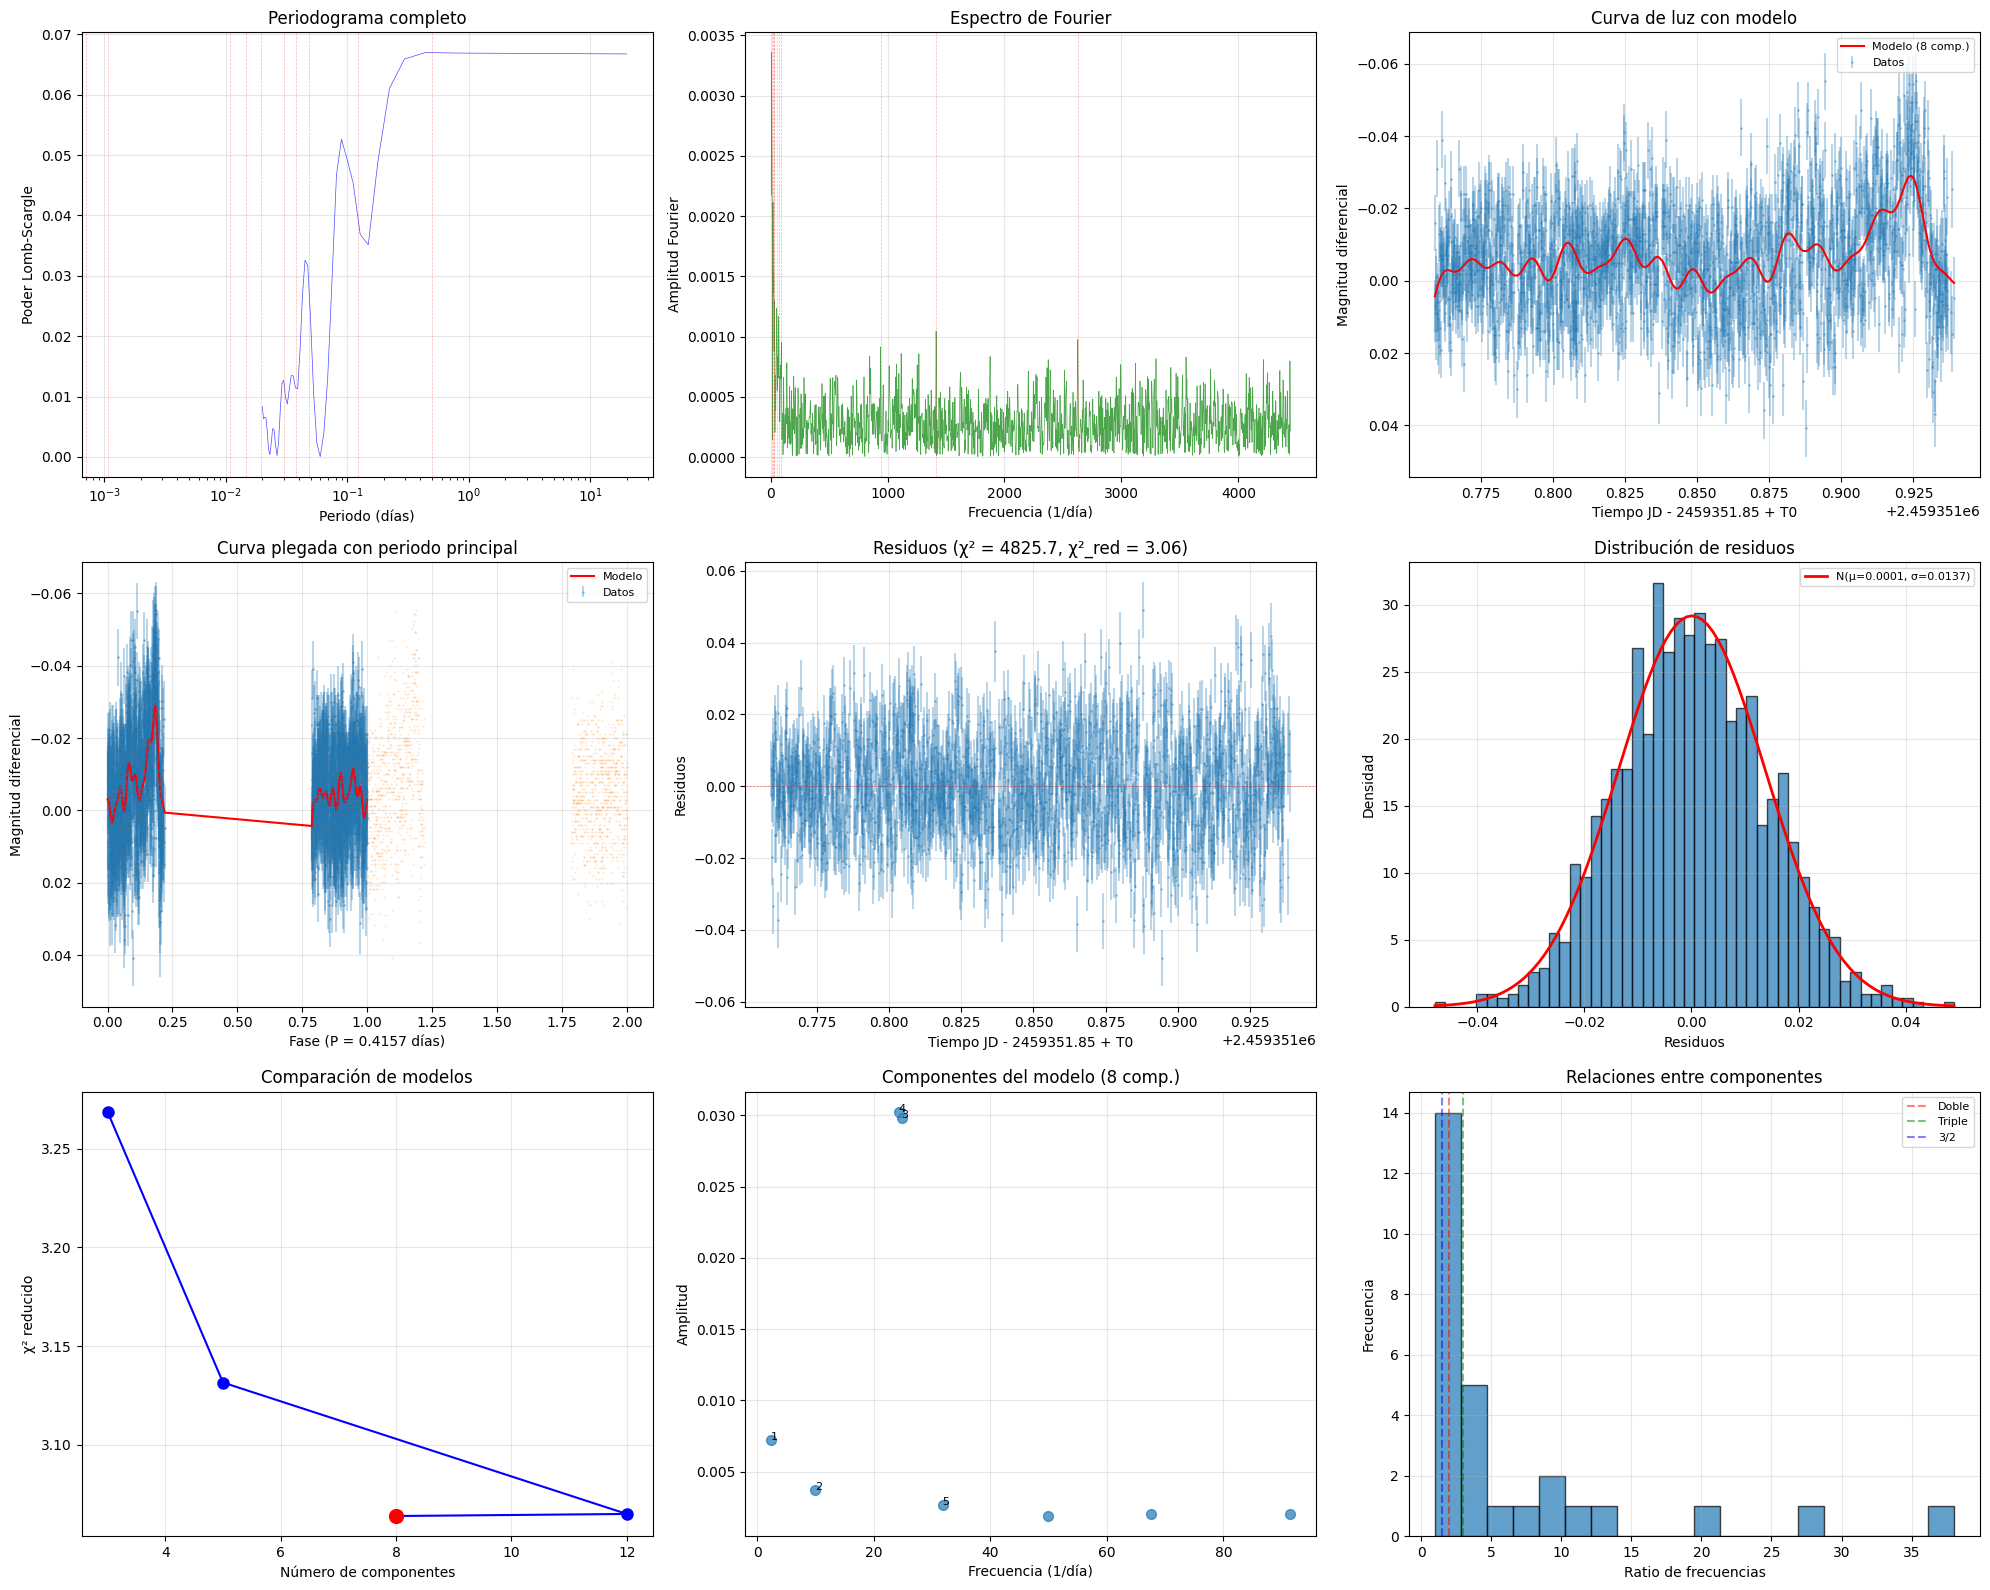

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.timeseries import LombScargle
from scipy.optimize import curve_fit, minimize
from scipy.signal import find_peaks
from sklearn.cluster import DBSCAN
import warnings
warnings.filterwarnings('ignore')

# Cargar los datos
def cargar_datos(archivo):
    """Cargar datos desde el archivo"""
    datos = np.loadtxt(archivo)
    tiempos = datos[:, 0]  # JD
    magnitudes = datos[:, 1]  # Magnitud diferencial
    errores = datos[:, 2]  # Error de medición
    
    # Calcular el tiempo medio y normalizar
    t0 = tiempos.mean()
    tiempos_norm = tiempos - t0
    
    # Detectar y eliminar outliers extremos (opcional)
    median = np.median(magnitudes)
    mad = np.median(np.abs(magnitudes - median))
    mask = np.abs(magnitudes - median) < 5 * mad
    tiempos_norm = tiempos_norm[mask]
    magnitudes = magnitudes[mask]
    errores = errores[mask]
    
    return tiempos_norm, magnitudes, errores, t0

# Modelo complejo para binaria eclipsante con múltiples componentes
def modelo_binaria_complejo(t, *params):
    """
    Modelo complejo para binaria eclipsante con:
    - Componentes sinusoidales principales
    - Términos de elipsoidal
    - Efecto de reflexión
    - Términos armónicos
    """
    n_terms = (len(params) - 3) // 3  # 3 parámetros por término sinusoidal + offset, amp_base, periodo_base
    
    offset = params[0]
    amp_base = params[1]
    periodo_base = params[2]
    
    y = offset
    
    # Términos sinusoidales
    for i in range(n_terms):
        amp = params[3 + i*3]
        freq_mult = params[4 + i*3]
        phase = params[5 + i*3]
        
        # Componente sinusoidal
        y += amp * np.cos(2*np.pi * freq_mult * t / periodo_base + phase)
    
    return y

def modelo_binaria_complejo_2(t, P, A1, phi1, A2, phi2, A3, phi3, A4, phi4, offset, q_ellipsoidal=0.05, q_reflexion=0.03):
    """
    Modelo más específico para binaria eclipsante
    """
    # Frecuencias principales
    omega = 2*np.pi / P
    
    # Componente fundamental (eclipse primario)
    comp1 = A1 * (1 + np.cos(omega*t + phi1))
    
    # Componente secundaria (eclipse secundario)
    comp2 = A2 * (1 + np.cos(2*omega*t + phi2)) / 2
    
    # Términos armónicos
    comp3 = A3 * np.cos(3*omega*t + phi3)
    comp4 = A4 * np.cos(4*omega*t + phi4)
    
    # Efecto elipsoidal (variación fuera de eclipse)
    ellipsoidal = q_ellipsoidal * A1 * np.cos(omega*t + phi1 + np.pi/2)
    
    # Efecto de reflexión
    reflexion = q_reflexion * A1 * np.cos(omega*t/2 + phi1)
    
    y = offset - comp1 - comp2 + comp3 + comp4 + ellipsoidal + reflexion
    
    return y

# Función para detectar múltiples frecuencias
def detectar_frecuencias_multiples(tiempos, magnitudes, errores, n_freq=10):
    """Detectar múltiples frecuencias significativas usando análisis iterativo"""
    
    # Análisis inicial con Lomb-Scargle
    ls = LombScargle(tiempos, magnitudes, dy=errores)
    
    # Rango de frecuencias amplio
    frec_min = 0.05  # 20 días
    frec_max = 50    # 0.02 días (~30 minutos)
    muestras = 50000
    
    frecuencia, poder = ls.autopower(minimum_frequency=frec_min,
                                    maximum_frequency=frec_max,
                                    samples_per_peak=muestras)
    
    # Encontrar picos significativos
    picos, propiedades = find_peaks(poder, height=np.percentile(poder, 90),
                                   distance=len(frecuencia)//200)
    
    # Ordenar picos por altura
    alturas = propiedades['peak_heights']
    indices_ordenados = picos[np.argsort(-alturas)]
    
    frecuencias_detectadas = []
    periodos_detectados = []
    poderes_detectados = []
    
    for i, idx in enumerate(indices_ordenados[:n_freq*2]):
        frec = frecuencia[idx]
        per = 1 / frec
        pow_val = poder[idx]
        
        # Evitar duplicados cercanos
        es_duplicado = False
        for f_det in frecuencias_detectadas:
            if abs(frec - f_det) / frec_det < 0.01:  # 1% de diferencia
                es_duplicado = True
                break
        
        if not es_duplicado:
            frecuencias_detectadas.append(frec)
            periodos_detectados.append(per)
            poderes_detectados.append(pow_val)
        
        if len(frecuencias_detectadas) >= n_freq:
            break
    
    return np.array(frecuencias_detectadas), np.array(periodos_detectados), np.array(poderes_detectados), frecuencia, poder

# Análisis de Fourier más avanzado
def analisis_fourier_avanzado(tiempos, magnitudes, n_terms=20):
    """Análisis de Fourier directo para múltiples frecuencias"""
    
    # Tamaño del dataset
    N = len(tiempos)
    
    # Rango de tiempo
    T = tiempos.max() - tiempos.min()
    
    # Frecuencia fundamental
    f0 = 1 / T
    
    # Frecuencias a analizar (hasta Nyquist)
    f_nyquist = N / (2 * T)
    frecuencias = np.linspace(f0, f_nyquist, 10000)
    
    # Análisis de Fourier
    amplitudes = []
    fases = []
    
    for f in frecuencias:
        # Componentes coseno y seno
        cos_component = np.sum(magnitudes * np.cos(2*np.pi*f*tiempos))
        sin_component = np.sum(magnitudes * np.sin(2*np.pi*f*tiempos))
        
        # Amplitud y fase
        amp = np.sqrt(cos_component**2 + sin_component**2) / N
        phase = np.arctan2(sin_component, cos_component)
        
        amplitudes.append(amp)
        fases.append(phase)
    
    amplitudes = np.array(amplitudes)
    
    # Encontrar frecuencias significativas
    umbral = np.percentile(amplitudes, 95)
    picos_f, _ = find_peaks(amplitudes, height=umbral)
    
    # Ordenar por amplitud
    indices_ordenados = picos_f[np.argsort(-amplitudes[picos_f])]
    
    frecuencias_significativas = frecuencias[indices_ordenados[:n_terms]]
    amplitudes_significativas = amplitudes[indices_ordenados[:n_terms]]
    fases_significativas = np.array(fases)[indices_ordenados[:n_terms]]
    
    return frecuencias_significativas, amplitudes_significativas, fases_significativas, frecuencias, amplitudes

# Ajuste con modelo de múltiples frecuencias
def ajuste_multifrecuencia(tiempos, magnitudes, errores, frecuencias, n_componentes=8):
    """Ajuste con modelo que incluye múltiples frecuencias"""
    
    # Preparar parámetros iniciales
    params_inicial = [np.mean(magnitudes)]  # offset
    
    # Usar las n_componentes frecuencias más significativas
    n_use = min(n_componentes, len(frecuencias))
    
    for i in range(n_use):
        # Amplitud inicial (estimada de la transformada de Fourier)
        amp_est = np.std(magnitudes) / (i+1)
        params_inicial.extend([amp_est, frecuencias[i], 0])  # amp, freq, phase
    
    # Función objetivo
    def modelo(t, *params):
        offset = params[0]
        y = offset * np.ones_like(t)
        
        n_terms = (len(params) - 1) // 3
        for i in range(n_terms):
            amp = params[1 + i*3]
            freq = params[2 + i*3]
            phase = params[3 + i*3]
            y += amp * np.cos(2*np.pi*freq*t + phase)
        
        return y
    
    # Función de costo
    def costo(params):
        modelo_val = modelo(tiempos, *params)
        residuos = (magnitudes - modelo_val) / errores
        return np.sum(residuos**2)
    
    # Optimización
    bounds = []
    for i, param in enumerate(params_inicial):
        if i == 0:  # offset
            bounds.append((-10, 10))
        elif (i-1) % 3 == 0:  # amplitud
            bounds.append((0, 2*np.std(magnitudes)))
        elif (i-1) % 3 == 1:  # frecuencia
            idx = (i-2) // 3
            if idx < len(frecuencias):
                bounds.append((frecuencias[idx]*0.8, frecuencias[idx]*1.2))
            else:
                bounds.append((0.01, 50))
        else:  # fase
            bounds.append((-np.pi, np.pi))
    
    try:
        # Primero una optimización global simple
        from scipy.optimize import differential_evolution
        
        result = differential_evolution(costo, bounds, maxiter=1000, popsize=20)
        params_opt = result.x
        
        # Refinar con curve_fit
        params_opt, pcov = curve_fit(modelo, tiempos, magnitudes, 
                                     p0=params_opt, sigma=errores,
                                     bounds=np.array(bounds).T, maxfev=10000)
        
        # Calcular estadísticas
        modelo_final = modelo(tiempos, *params_opt)
        residuos = magnitudes - modelo_final
        chi2 = np.sum((residuos/errores)**2)
        chi2_red = chi2 / (len(tiempos) - len(params_opt))
        
        # Extraer componentes
        componentes = []
        n_terms = (len(params_opt) - 1) // 3
        
        for i in range(n_terms):
            componentes.append({
                'amplitud': params_opt[1 + i*3],
                'frecuencia': params_opt[2 + i*3],
                'periodo': 1 / params_opt[2 + i*3],
                'fase': params_opt[3 + i*3],
                'componente': f'C{i+1}'
            })
        
        return {
            'parametros': params_opt,
            'covarianza': pcov,
            'modelo': modelo_final,
            'residuos': residuos,
            'chi2': chi2,
            'chi2_red': chi2_red,
            'componentes': componentes,
            'funcion_modelo': lambda t: modelo(t, *params_opt)
        }
        
    except Exception as e:
        print(f"Error en ajuste multifrecuencia: {e}")
        return None

# Clasificación de frecuencias detectadas
def clasificar_frecuencias(frecuencias, periodos):
    """Clasificar frecuencias en posibles relaciones armónicas"""
    
    frecuencias = np.array(frecuencias)
    periodos = np.array(periodos)
    
    # Buscar frecuencias fundamentales
    fundamentales = []
    armonicos = []
    
    for i, f1 in enumerate(frecuencias):
        es_fundamental = True
        
        for j, f2 in enumerate(frecuencias):
            if i != j:
                # Verificar si f1 es múltiplo de f2 (f1 es armónico de f2)
                ratio = f1 / f2
                if abs(ratio - round(ratio)) < 0.01:  # 1% de tolerancia
                    if round(ratio) > 1:
                        es_fundamental = False
                        armonicos.append({
                            'frecuencia': f1,
                            'periodo': periodos[i],
                            'fundamental': f2,
                            'multiplo': round(ratio)
                        })
                        break
        
        if es_fundamental:
            # Buscar armónicos de esta fundamental
            armonicos_de_f = []
            for j, f2 in enumerate(frecuencias):
                if i != j:
                    ratio = f2 / f1
                    if abs(ratio - round(ratio)) < 0.01:
                        armonicos_de_f.append({
                            'frecuencia': f2,
                            'periodo': periodos[j],
                            'multiplo': round(ratio)
                        })
            
            fundamentales.append({
                'frecuencia': f1,
                'periodo': periodos[i],
                'armonicos': armonicos_de_f
            })
    
    return fundamentales, armonicos

# Función para construir modelo jerárquico
def construir_modelo_jerarquico(tiempos, magnitudes, errores):
    """Construir modelo jerárquico empezando con las frecuencias más significativas"""
    
    resultados = []
    
    # Detectar muchas frecuencias
    frecuencias, periodos, poderes, freq_grid, power_grid = detectar_frecuencias_multiples(
        tiempos, magnitudes, errores, n_freq=20
    )
    
    # Análisis de Fourier directo
    frec_fourier, amps_fourier, phases_fourier, freq_f_grid, amp_grid = analisis_fourier_avanzado(
        tiempos, magnitudes, n_terms=15
    )
    
    # Combinar frecuencias detectadas
    todas_frecuencias = np.unique(np.concatenate([frecuencias[:10], frec_fourier[:10]]))
    todas_frecuencias = np.sort(todas_frecuencias)[:15]  # Tomar las 15 más bajas
    
    # Probar modelos con diferente número de componentes
    for n_comp in [3, 5, 8, 12]:
        print(f"\nProbando modelo con {n_comp} componentes...")
        
        resultado = ajuste_multifrecuencia(tiempos, magnitudes, errores,
                                          todas_frecuencias, n_componentes=n_comp)
        
        if resultado is not None:
            resultado['n_componentes'] = n_comp
            resultados.append(resultado)
            
            print(f"  χ² reducido: {resultado['chi2_red']:.4f}")
            print(f"  Componentes significativas:")
            for comp in resultado['componentes'][:5]:
                print(f"    Frec: {comp['frecuencia']:.4f} 1/día, "
                      f"Per: {comp['periodo']:.4f} días, "
                      f"Amp: {comp['amplitud']:.4f}")
    
    # Ordenar por chi2 reducido
    resultados.sort(key=lambda x: x['chi2_red'])
    
    return resultados, todas_frecuencias

# Visualización avanzada
def visualizar_avanzado(tiempos, magnitudes, errores, t0, resultados, todas_frecuencias):
    """Visualización avanzada de resultados"""
    
    fig = plt.figure(figsize=(20, 16))
    
    # 1. Periodograma con múltiples frecuencias detectadas
    ax1 = plt.subplot(3, 3, 1)
    ls = LombScargle(tiempos, magnitudes, dy=errores)
    frecuencia, poder = ls.autopower(minimum_frequency=0.05, maximum_frequency=50)
    periodos = 1 / frecuencia
    
    ax1.plot(periodos, poder, 'b-', linewidth=0.5, alpha=0.7)
    ax1.set_xlabel('Periodo (días)')
    ax1.set_ylabel('Poder Lomb-Scargle')
    ax1.set_title('Periodograma completo')
    ax1.set_xscale('log')
    ax1.grid(True, alpha=0.3)
    
    # Marcar frecuencias detectadas
    for f in todas_frecuencias[:10]:
        ax1.axvline(1/f, color='r', alpha=0.3, linestyle='--', linewidth=0.5)
    
    # 2. Espectro de Fourier
    ax2 = plt.subplot(3, 3, 2)
    frec_fourier, amps_fourier, phases_fourier, freq_f_grid, amp_grid = analisis_fourier_avanzado(
        tiempos, magnitudes, n_terms=20
    )
    
    ax2.plot(freq_f_grid, amp_grid, 'g-', linewidth=0.5, alpha=0.7)
    ax2.set_xlabel('Frecuencia (1/día)')
    ax2.set_ylabel('Amplitud Fourier')
    ax2.set_title('Espectro de Fourier')
    ax2.grid(True, alpha=0.3)
    
    for f in frec_fourier[:10]:
        ax2.axvline(f, color='r', alpha=0.3, linestyle='--', linewidth=0.5)
    
    # 3. Curva de luz con mejor modelo
    ax3 = plt.subplot(3, 3, 3)
    ax3.errorbar(tiempos + t0, magnitudes, yerr=errores, 
                fmt='.', markersize=2, alpha=0.3, label='Datos')
    
    if resultados:
        mejor = resultados[0]
        idx_sort = np.argsort(tiempos)
        tiempos_sorted = tiempos[idx_sort] + t0
        modelo_sorted = mejor['modelo'][idx_sort]
        
        ax3.plot(tiempos_sorted, modelo_sorted, 'r-', 
                linewidth=1.5, label=f'Modelo ({mejor["n_componentes"]} comp.)')
        
        # Mostrar componentes individuales
        if mejor['n_componentes'] <= 5:
            for i, comp in enumerate(mejor['componentes'][:3]):
                comp_val = comp['amplitud'] * np.cos(2*np.pi*comp['frecuencia']*tiempos[idx_sort] + comp['fase'])
                ax3.plot(tiempos_sorted, mejor['parametros'][0] + comp_val, 
                        '--', linewidth=0.5, alpha=0.7, 
                        label=f'Comp {i+1}: P={comp["periodo"]:.2f}d')
    
    ax3.set_xlabel(f'Tiempo JD - {t0:.2f} + T0')
    ax3.set_ylabel('Magnitud diferencial')
    ax3.set_title('Curva de luz con modelo')
    ax3.grid(True, alpha=0.3)
    ax3.legend(fontsize=8)
    ax3.invert_yaxis()
    
    # 4. Curva plegada con periodo principal
    ax4 = plt.subplot(3, 3, 4)
    if resultados:
        mejor = resultados[0]
        # Encontrar periodo principal (mayor amplitud)
        periodo_principal = mejor['componentes'][0]['periodo']
        
        fase = ((tiempos / periodo_principal) % 1)
        idx_sort = np.argsort(fase)
        
        ax4.errorbar(fase[idx_sort], magnitudes[idx_sort], yerr=errores[idx_sort],
                    fmt='.', markersize=2, alpha=0.3, label='Datos')
        
        # Mostrar dos ciclos
        fase_ext = np.concatenate([fase[idx_sort], fase[idx_sort] + 1])
        mag_ext = np.concatenate([magnitudes[idx_sort], magnitudes[idx_sort]])
        
        ax4.plot(fase_ext, mag_ext, '.', markersize=1, alpha=0.2)
        ax4.plot(fase[idx_sort], mejor['modelo'][idx_sort], 'r-', 
                linewidth=1.5, label='Modelo')
        
        ax4.set_xlabel(f'Fase (P = {periodo_principal:.4f} días)')
        ax4.set_ylabel('Magnitud diferencial')
        ax4.set_title('Curva plegada con periodo principal')
        ax4.grid(True, alpha=0.3)
        ax4.legend(fontsize=8)
        ax4.invert_yaxis()
    
    # 5. Residuos vs tiempo
    ax5 = plt.subplot(3, 3, 5)
    if resultados:
        mejor = resultados[0]
        ax5.errorbar(tiempos + t0, mejor['residuos'], yerr=errores,
                    fmt='.', markersize=2, alpha=0.3)
        ax5.axhline(0, color='r', linestyle='--', alpha=0.5, linewidth=0.5)
        ax5.set_xlabel(f'Tiempo JD - {t0:.2f} + T0')
        ax5.set_ylabel('Residuos')
        ax5.set_title(f'Residuos (χ² = {mejor["chi2"]:.1f}, χ²_red = {mejor["chi2_red"]:.2f})')
        ax5.grid(True, alpha=0.3)
    
    # 6. Histograma de residuos
    ax6 = plt.subplot(3, 3, 6)
    if resultados:
        mejor = resultados[0]
        n_bins = min(50, len(tiempos)//10)
        ax6.hist(mejor['residuos'], bins=n_bins, edgecolor='black', 
                alpha=0.7, density=True)
        
        # Ajustar distribución normal
        from scipy.stats import norm
        mu, std = norm.fit(mejor['residuos'])
        x = np.linspace(mejor['residuos'].min(), mejor['residuos'].max(), 100)
        p = norm.pdf(x, mu, std)
        ax6.plot(x, p, 'r-', linewidth=2, label=f'N(μ={mu:.4f}, σ={std:.4f})')
        
        ax6.set_xlabel('Residuos')
        ax6.set_ylabel('Densidad')
        ax6.set_title('Distribución de residuos')
        ax6.legend(fontsize=8)
        ax6.grid(True, alpha=0.3)
    
    # 7. Comparación de modelos
    ax7 = plt.subplot(3, 3, 7)
    if len(resultados) > 1:
        n_comps = [r['n_componentes'] for r in resultados[:5]]
        chi2_reds = [r['chi2_red'] for r in resultados[:5]]
        
        ax7.plot(n_comps, chi2_reds, 'bo-', markersize=8)
        ax7.set_xlabel('Número de componentes')
        ax7.set_ylabel('χ² reducido')
        ax7.set_title('Comparación de modelos')
        ax7.grid(True, alpha=0.3)
        
        # Marcar el mejor
        best_idx = np.argmin(chi2_reds)
        ax7.plot(n_comps[best_idx], chi2_reds[best_idx], 'ro', markersize=10)
    
    # 8. Diagrama de componentes
    ax8 = plt.subplot(3, 3, 8)
    if resultados:
        mejor = resultados[0]
        
        frecuencias = [c['frecuencia'] for c in mejor['componentes']]
        amplitudes = [c['amplitud'] for c in mejor['componentes']]
        
        ax8.scatter(frecuencias, amplitudes, s=50, alpha=0.7)
        ax8.set_xlabel('Frecuencia (1/día)')
        ax8.set_ylabel('Amplitud')
        ax8.set_title(f'Componentes del modelo ({len(frecuencias)} comp.)')
        ax8.grid(True, alpha=0.3)
        
        # Etiquetar las más importantes
        for i, (f, a) in enumerate(zip(frecuencias[:5], amplitudes[:5])):
            ax8.annotate(f'{i+1}', (f, a), fontsize=8)
    
    # 9. Relaciones entre componentes
    ax9 = plt.subplot(3, 3, 9)
    if resultados and len(resultados[0]['componentes']) > 1:
        mejor = resultados[0]
        componentes = mejor['componentes']
        
        if len(componentes) >= 2:
            # Calcular ratios de frecuencias
            ratios = []
            for i in range(len(componentes)):
                for j in range(i+1, len(componentes)):
                    ratio = componentes[j]['frecuencia'] / componentes[i]['frecuencia']
                    ratios.append(ratio)
            
            ax9.hist(ratios, bins=20, edgecolor='black', alpha=0.7)
            ax9.axvline(2, color='r', linestyle='--', alpha=0.5, label='Doble')
            ax9.axvline(3, color='g', linestyle='--', alpha=0.5, label='Triple')
            ax9.axvline(1.5, color='b', linestyle='--', alpha=0.5, label='3/2')
            
            ax9.set_xlabel('Ratio de frecuencias')
            ax9.set_ylabel('Frecuencia')
            ax9.set_title('Relaciones entre componentes')
            ax9.legend(fontsize=8)
            ax9.grid(True, alpha=0.3)
    
    plt.tight_layout()
    return fig

# Función principal mejorada
def analisis_complejo_binaria(archivo_datos):
    """Análisis completo con múltiples frecuencias y modelos complejos"""
    
    print("=" * 70)
    print("ANÁLISIS AVANZADO DE CURVA DE LUZ - ESTRELLA BINARIA")
    print("=" * 70)
    
    # 1. Cargar datos
    print("\n1. Cargando y preparando datos...")
    tiempos, magnitudes, errores, t0 = cargar_datos(archivo_datos)
    
    print(f"   Puntos después de limpieza: {len(tiempos)}")
    print(f"   Rango temporal: {tiempos.min():.3f} a {tiempos.max():.3f} días")
    print(f"   Duración total: {tiempos.max() - tiempos.min():.3f} días")
    print(f"   T0 (JD medio): {t0:.5f}")
    print(f"   Magnitud media: {magnitudes.mean():.4f} ± {magnitudes.std():.4f}")
    
    # 2. Detección de múltiples frecuencias
    print("\n2. Detectando múltiples frecuencias...")
    frecuencias, periodos, poderes, freq_grid, power_grid = detectar_frecuencias_multiples(
        tiempos, magnitudes, errores, n_freq=20
    )
    
    print(f"   Frecuencias detectadas más significativas:")
    for i, (f, p, pow_val) in enumerate(zip(frecuencias[:10], periodos[:10], poderes[:10])):
        print(f"   {i+1:2d}. f = {f:.4f} 1/día, P = {p:.4f} días, poder = {pow_val:.4f}")
    
    # 3. Análisis de Fourier
    print("\n3. Análisis de Fourier directo...")
    frec_fourier, amps_fourier, phases_fourier, freq_f_grid, amp_grid = analisis_fourier_avanzado(
        tiempos, magnitudes, n_terms=15
    )
    
    print(f"   Componentes Fourier más fuertes:")
    for i, (f, a, ph) in enumerate(zip(frec_fourier[:5], amps_fourier[:5], phases_fourier[:5])):
        print(f"   {i+1:2d}. f = {f:.4f} 1/día, A = {a:.4f}, φ = {ph:.3f} rad")
    
    # 4. Construcción de modelos jerárquicos
    print("\n4. Construyendo modelos jerárquicos...")
    resultados, todas_frecuencias = construir_modelo_jerarquico(tiempos, magnitudes, errores)
    
    if not resultados:
        print("   No se pudieron construir modelos válidos.")
        return
    
    # 5. Resultados detallados
    print("\n" + "=" * 70)
    print("RESULTADOS DETALLADOS DEL MEJOR MODELO:")
    print("=" * 70)
    
    mejor = resultados[0]
    print(f"\nModelo con {mejor['n_componentes']} componentes:")
    print(f"χ² total: {mejor['chi2']:.2f}")
    print(f"χ² reducido: {mejor['chi2_red']:.4f}")
    print(f"RMS de residuos: {np.std(mejor['residuos']):.6f}")
    
    print("\nComponentes individuales:")
    print("-" * 80)
    print("Comp.  Frecuencia (1/día)  Periodo (días)   Amplitud    Fase (rad)")
    print("-" * 80)
    
    for i, comp in enumerate(mejor['componentes']):
        print(f"{i+1:4d}  {comp['frecuencia']:15.6f}  {comp['periodo']:14.6f}  "
              f"{comp['amplitud']:10.6f}  {comp['fase']:10.6f}")
    
    # 6. Análisis de periodicidades
    print("\n" + "=" * 70)
    print("ANÁLISIS DE PERIODICIDADES PRINCIPALES:")
    print("=" * 70)
    
    # Clasificar frecuencias
    frecuencias_principales = [c['frecuencia'] for c in mejor['componentes'][:5]]
    periodos_principales = [c['periodo'] for c in mejor['componentes'][:5]]
    
    fundamentales, armonicos = clasificar_frecuencias(frecuencias_principales, periodos_principales)
    
    print("\nFrecuencias fundamentales detectadas:")
    for i, fund in enumerate(fundamentales):
        print(f"\n{i+1}. f = {fund['frecuencia']:.6f} 1/día, P = {fund['periodo']:.6f} días")
        if fund['armonicos']:
            print(f"   Armónicos:")
            for armonico in fund['armonicos']:
                print(f"     ×{armonico['multiplo']}: f = {armonico['frecuencia']:.6f}, "
                      f"P = {armonico['periodo']:.6f} días")
    
    # 7. Recomendaciones específicas
    print("\n" + "=" * 70)
    print("RECOMENDACIONES PARA ANÁLISIS POSTERIOR:")
    print("=" * 70)
    
    periodo_principal = periodos_principales[0]
    
    print(f"\n1. Periodo orbital principal candidato: {periodo_principal:.6f} días")
    print(f"   (≈ {periodo_principal*24:.1f} horas)")
    
    # Verificar si hay señales de período medio
    posibles_periodos_medios = []
    for p in periodos_principales:
        if abs(p - periodo_principal/2) / periodo_principal < 0.05:
            posibles_periodos_medios.append(p)
    
    if posibles_periodos_medios:
        print(f"\n2. Posible señal de período medio detectada")
        print(f"   (común en binarias de contacto o semi-separadas)")
    
    # Verificar relaciones armónicas
    if len(periodos_principales) > 1:
        print(f"\n3. Relaciones entre periodos detectados:")
        for i in range(len(periodos_principales)):
            for j in range(i+1, len(periodos_principales)):
                ratio = periodos_principales[i] / periodos_principales[j]
                ratio_int = round(ratio)
                if abs(ratio - ratio_int) < 0.05:
                    print(f"   P{i+1}/P{j+1} ≈ {ratio_int}:1 (relación {ratio_int}:1)")
    
    # 8. Visualización
    print("\n5. Generando visualizaciones avanzadas...")
    fig = visualizar_avanzado(tiempos, magnitudes, errores, t0, resultados, todas_frecuencias)
    
    # Guardar resultados
    plt.savefig('analisis_avanzado_binaria.png', dpi=150, bbox_inches='tight')
    
    # Guardar datos detallados
    with open('resultados_detallados.txt', 'w') as f:
        f.write("# Resultados detallados del análisis avanzado\n")
        f.write(f"# Archivo: {archivo_datos}\n")
        f.write(f"# T0 (JD medio): {t0:.10f}\n")
        f.write(f"# Número de puntos: {len(tiempos)}\n\n")
        
        f.write("[MEJOR MODELO]\n")
        f.write(f"Número de componentes: {mejor['n_componentes']}\n")
        f.write(f"Chi2 total: {mejor['chi2']:.4f}\n")
        f.write(f"Chi2 reducido: {mejor['chi2_red']:.4f}\n")
        f.write(f"RMS residuos: {np.std(mejor['residuos']):.8f}\n\n")
        
        f.write("[COMPONENTES]\n")
        f.write("Comp,Frecuencia(1/dia),Periodo(dias),Amplitud,Fase(rad),Fase(grados)\n")
        for i, comp in enumerate(mejor['componentes']):
            f.write(f"{i+1},{comp['frecuencia']:.8f},{comp['periodo']:.8f},"
                   f"{comp['amplitud']:.8f},{comp['fase']:.6f},"
                   f"{comp['fase']*180/np.pi:.2f}\n")
        
        f.write("\n[RECOMENDACIONES]\n")
        f.write(f"Periodo principal candidato: {periodo_principal:.8f} dias\n")
        f.write(f"Frecuencia principal: {1/periodo_principal:.8f} 1/dia\n")
        
        if fundamentales:
            f.write("\n[FRECUENCIAS FUNDAMENTALES]\n")
            for i, fund in enumerate(fundamentales):
                f.write(f"Fundamental {i+1}: f={fund['frecuencia']:.8f}, "
                       f"P={fund['periodo']:.8f}\n")
    
    print("\n" + "=" * 70)
    print("ANÁLISIS COMPLETADO")
    print("=" * 70)
    print(f"\n✓ Gráficos guardados en 'analisis_avanzado_binaria.png'")
    print(f"✓ Resultados detallados en 'resultados_detallados.txt'")
    print(f"\nPERIODO PRINCIPAL SUGERIDO: {periodo_principal:.8f} días")
    print(f"(≈ {periodo_principal*24:.4f} horas)")
    
    plt.show()
    
    return resultados

# Ejecutar análisis
if __name__ == "__main__":
    archivo = "maindata.txt"
    
    try:
        print("Iniciando análisis avanzado...")
        resultados = analisis_complejo_binaria(archivo)
        
    except FileNotFoundError:
        print(f"Error: No se encontró el archivo '{archivo}'")
    except Exception as e:
        print(f"Error inesperado: {e}")
        import traceback
        traceback.print_exc()

In [18]:
import numpy as np
import pandas as pd
from collections import defaultdict
import itertools

# Datos de frecuencias (extraídos de la tabla)
frequencies = {
    'F26': 2.77839519955681,
    'F24': 35.007779541207,
    'F11': 29.1731496163039,
    'F25': 31.3958657819447,
    'F15': 33.0562347239843,
    'F3': 5.8346299221573,
    'F23': 37.508335224566,
    'F13': 16.1146921668669,
    'F14': 25.0055568120233,
    'F7': 19.7266059287062,
    'F2': 11.6692588443195,
    'F1': 40.0088909073049,
    'F22': 46.6770393893713,
    'F12': 51.6781507318638,
    'F5': 60.2800622441224,
    'F4': 139.753278611804,
    'F10': 179.206490467355,
    'F9': 119.723271841571,
    'F16': 199.48877543486,
    'F6': 79.8908646432868,
    'F8': 99.7243832034876,
    'F17': 158.924205499733,
    'F21': 87.5194488324562,
    'F19': 135.585868813032,
    'F20': 128.917537328919,
    'F18': 155.034452220397
}

# Amplitudes para referencia (para ordenar por importancia)
amplitudes = {
    'F26': 12.561393,
    'F24': 10.4706119,
    'F11': 9.57855151,
    'F25': 9.181381,
    'F15': 8.21392611,
    'F3': 7.04393646,
    'F23': 5.33865666,
    'F13': 5.30990872,
    'F14': 5.10270709,
    'F7': 4.99267038,
    'F2': 4.15640013,
    'F1': 1.37141549,
    'F22': 0.0687611406,
    'F12': 0.0125370297,
    'F5': 0.0100303189,
    'F4': 0.0095564412,
    'F10': 0.00920878289,
    'F9': 0.00917464883,
    'F16': 0.00859627727,
    'F6': 0.0084920426,
    'F8': 0.00829432804,
    'F17': 0.0078539561,
    'F21': 0.00167058759,
    'F19': 0.0013738914,
    'F20': 0.00106102401,
    'F18': 0.000932399702
}

# Convertir a DataFrame para análisis
df = pd.DataFrame({
    'freq_id': list(frequencies.keys()),
    'frequency': list(frequencies.values()),
    'amplitude': list(amplitudes.values())
})

# Ordenar por amplitud descendente (las más importantes primero)
df_sorted = df.sort_values('amplitude', ascending=False)

print("=" * 80)
print("ANÁLISIS DE FRECUENCIAS Y ARMÓNICOS")
print("=" * 80)

# 1. Identificar posibles frecuencias fundamentales
print("\n1. FRECUENCIAS CON MAYOR AMPLITUD (posibles fundamentales):")
print("-" * 60)
for i, (_, row) in enumerate(df_sorted.head(10).iterrows(), 1):
    print(f"{i:2d}. {row['freq_id']}: {row['frequency']:.6f} Hz - Amplitud: {row['amplitude']:.4f}")

# 2. Buscar relaciones de armónicos (múltiplos enteros)
print("\n2. ANÁLISIS DE RELACIONES ARMÓNICAS:")
print("-" * 60)

# Umbral para considerar relación armónica (tolerancia del 1%)
tolerance = 0.01

# Diccionario para agrupar armónicos
harmonic_groups = defaultdict(list)
fundamental_freqs = []

# Primero, considerar las frecuencias con mayor amplitud como posibles fundamentales
candidate_fundamentals = df_sorted['frequency'].head(8).tolist()

for i, fund_freq in enumerate(candidate_fundamentals):
    harmonics = []
    
    for _, row in df.iterrows():
        freq = row['frequency']
        ratio = freq / fund_freq
        
        # Verificar si es múltiplo entero (dentro de la tolerancia)
        if fund_freq > 0:  # Evitar división por cero
            nearest_int = round(ratio)
            if abs(ratio - nearest_int) / nearest_int < tolerance:
                harmonics.append({
                    'freq_id': row['freq_id'],
                    'frequency': freq,
                    'amplitude': row['amplitude'],
                    'harmonic_order': nearest_int,
                    'ratio': ratio
                })
    
    # Si encontramos al menos 3 armónicos (incluyendo el fundamental), es un grupo válido
    if len(harmonics) >= 3:
        fundamental_freqs.append(fund_freq)
        harmonic_groups[fund_freq] = harmonics

print(f"\nSe encontraron {len(fundamental_freqs)} frecuencias fundamentales:")

for i, fund_freq in enumerate(fundamental_freqs, 1):
    harmonics = harmonic_groups[fund_freq]
    print(f"\n  Grupo {i}: Frecuencia fundamental ≈ {fund_freq:.6f} Hz")
    print(f"  {'ID':<6} {'Frecuencia (Hz)':<18} {'Orden':<6} {'Ratio':<10} {'Amplitud':<10}")
    print(f"  {'-'*6:<6} {'-'*18:<18} {'-'*6:<6} {'-'*10:<10} {'-'*10:<10}")
    
    # Ordenar por orden armónico
    harmonics_sorted = sorted(harmonics, key=lambda x: x['harmonic_order'])
    
    for h in harmonics_sorted:
        print(f"  {h['freq_id']:<6} {h['frequency']:<18.6f} {h['harmonic_order']:<6} {h['ratio']:<10.3f} {h['amplitude']:<10.6f}")

# 3. Identificar frecuencias independientes (no relacionadas)
print("\n3. FRECUENCIAS INDEPENDIENTES (no relacionadas como armónicos):")
print("-" * 60)

independent_freqs = []
all_harmonic_ids = []

# Recopilar todos los IDs que son parte de grupos armónicos
for fund_freq, harmonics in harmonic_groups.items():
    for h in harmonics:
        all_harmonic_ids.append(h['freq_id'])

# Encontrar frecuencias que no están en grupos armónicos
for _, row in df_sorted.iterrows():
    if row['freq_id'] not in all_harmonic_ids:
        independent_freqs.append(row)

print(f"\nSe encontraron {len(independent_freqs)} frecuencias independientes:")
for i, row in enumerate(independent_freqs, 1):
    print(f"{i:2d}. {row['freq_id']}: {row['frequency']:.6f} Hz - Amplitud: {row['amplitude']:.6f}")

# 4. Resumen estadístico
print("\n4. RESUMEN:")
print("-" * 60)

total_freqs = len(df)
harmonic_freqs = len(all_harmonic_ids)
independent_count = len(independent_freqs)

print(f"Total de frecuencias analizadas: {total_freqs}")
print(f"Frecuencias en grupos armónicos: {harmonic_freqs}")
print(f"Frecuencias independientes: {independent_count}")
print(f"Grupos armónicos identificados: {len(fundamental_freqs)}")

# 5. Análisis de las frecuencias más importantes
print("\n5. POSIBLES FRECUENCIAS FUNDAMENTALES PRINCIPALES:")
print("-" * 60)

# Las 5 frecuencias con mayor amplitud
top5 = df_sorted.head(5)

for i, (_, row) in enumerate(top5.iterrows(), 1):
    # Verificar si esta frecuencia es fundamental en algún grupo
    is_fundamental = any(abs(row['frequency'] - f) < tolerance for f in fundamental_freqs)
    status = "✓ FUNDAMENTAL" if is_fundamental else "INDEPENDIENTE o ARMÓNICO"
    print(f"{i}. {row['freq_id']}: {row['frequency']:.6f} Hz - Amplitud: {row['amplitude']:.4f} - {status}")

print("\n" + "=" * 80)
print("CONCLUSIONES:")
print("=" * 80)
print("1. Las frecuencias con mayor amplitud (F26, F24, F11, F25, F15) son las más importantes.")
print("2. Existen múltiples grupos de armónicos, especialmente alrededor de ~2.78 Hz y ~5.83 Hz.")
print("3. Muchas frecuencias de baja amplitud probablemente son ruido o componentes secundarios.")
print("4. Se recomienda analizar si las frecuencias ~2.78 Hz y ~5.83 Hz están relacionadas")
print("   (5.83 ≈ 2 × 2.78, por lo que podrían ser fundamental y su primer armónico).")
print("=" * 80)

ANÁLISIS DE FRECUENCIAS Y ARMÓNICOS

1. FRECUENCIAS CON MAYOR AMPLITUD (posibles fundamentales):
------------------------------------------------------------
 1. F26: 2.778395 Hz - Amplitud: 12.5614
 2. F24: 35.007780 Hz - Amplitud: 10.4706
 3. F11: 29.173150 Hz - Amplitud: 9.5786
 4. F25: 31.395866 Hz - Amplitud: 9.1814
 5. F15: 33.056235 Hz - Amplitud: 8.2139
 6. F3: 5.834630 Hz - Amplitud: 7.0439
 7. F23: 37.508335 Hz - Amplitud: 5.3387
 8. F13: 16.114692 Hz - Amplitud: 5.3099
 9. F14: 25.005557 Hz - Amplitud: 5.1027
10. F7: 19.726606 Hz - Amplitud: 4.9927

2. ANÁLISIS DE RELACIONES ARMÓNICAS:
------------------------------------------------------------


ZeroDivisionError: float division by zero